In [1]:
#  Required imports

import numpy as np
from   scipy import stats
from matplotlib import pyplot as plt
from iminuit import Minuit

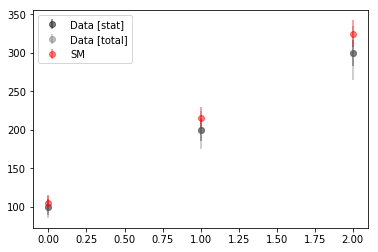

In [2]:
#  Standard Model prediction

observed_dataset  = np.array([105., 215., 325.])

SM_pred           = np.array([100., 200., 300.])
expected_stat_err = np.sqrt(SM_pred)
num_observations  = len(SM_pred)

rel_lumi_err = 0.10
expected_lumi_err = rel_lumi_err * SM_pred
expected_total_err = np.sqrt(expected_stat_err*expected_stat_err + expected_lumi_err*expected_lumi_err)

#  Plot Asimov
plt.errorbar(np.arange(num_observations), SM_pred, yerr=expected_stat_err, fmt="o", alpha=0.5, c="k", label="Data [stat]")
plt.errorbar(np.arange(num_observations), SM_pred, yerr=expected_total_err, fmt="o", alpha=0.5, c="grey", label="Data [total]")
plt.errorbar(np.arange(num_observations), observed_dataset, yerr=expected_stat_err, fmt="o", alpha=0.5, c="r", label="SM")
plt.legend(loc="best")
plt.show()

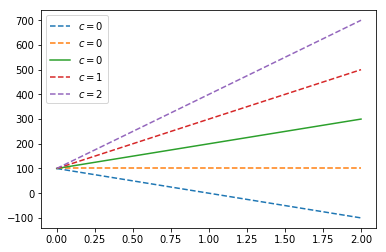

In [3]:
#  EFT prediction (linear in c)

EFT_pred = np.array([0., 100., 200.])

def pred (c) :
    return SM_pred + c*EFT_pred

#  Plot EFT
plt.plot(np.arange(num_observations), pred(-2), "--", label="$c=0$")
plt.plot(np.arange(num_observations), pred(-1), "--", label="$c=0$")
plt.plot(np.arange(num_observations), pred(0), "-", label="$c=0$")
plt.plot(np.arange(num_observations), pred(1), "--", label="$c=1$")
plt.plot(np.arange(num_observations), pred(2), "--", label="$c=2$")
plt.legend(loc="upper left")
plt.show()

The stats-only likelihood function is
$\mathcal{L}\left({\vec x} | c\right) = \prod_{i \in \text{bins}} \mathcal{G}\left(x_i; p_i(c), \sigma^\text{stat}_i\right) $  (assuming no bin-to-bin correlations)

Now we want to allow the measured values to be pulled by some **fraction** $\theta_\text{lumi}$ of some **amplitude** ${\vec \epsilon}^\text{lumi}$. This is done by replacing $\vec x$ with $\vec x+\theta_\text{lumi}\cdot {\vec\epsilon}^\text{lumi}$:

$\mathcal{L}\left({\vec x} | c\right) = \prod_{i \in \text{bins}} \mathcal{G}\left(x_i+\theta_i\epsilon^\text{lumi}_i; p_i(c), \sigma^\text{stat}_i\right) $

But, we want to model the luminosity uncertainty as Gaussian. This means that the probability density of $\theta_\text{lumi}$ is a standard normal Gaussian. This gets multiplied into the likelihood, to penalise pulls away from the preferred value of $\theta_\text{lumi}=0$. Pulls of $\theta_\text{lumi}=\pm1$ are allowed, but come with corresponding likelihood penalty equal to a factor of $\mathcal{G}\left(\theta^\text{lumi}:0,1\right)$.

In [4]:
#  likelihood is prob_density(observing dataset x| model parameter c, and NP theta)

def likelihood (x, c, NP_lumi) :
    x = (1. + NP_lumi*rel_lumi_err) * x
    return np.prod(stats.norm.pdf(x, pred(c), expected_stat_err)) * stats.norm.pdf(NP_lumi, 0, 1)

def TNLL (x, c, NP_lumi) :
    return -2. * np.log(likelihood(x, c, NP_lumi))

In [5]:
#  Set up Minuit object capablke of fitting for maximum likelihood

fit_func = lambda params : TNLL(observed_dataset, params[0], params[1])
m = Minuit.from_array_func(fit_func, (0.,0.,), error=(1.,1.,), name=("c", "NP_lumi"), errordef=1.)

In [6]:
#  Fit for best values of c and theta

m.migrad()
m.minos()
print(m.get_param_states())

---------------------------------------------------------------------------------------------
|   | Name    |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
---------------------------------------------------------------------------------------------
| 0 | c       |    0.09   |    0.14   |   -0.14    |    0.14    |         |         |       |
| 1 | NP_lumi |   -0.26   |    0.67   |   -0.67    |    0.67    |         |         |       |
---------------------------------------------------------------------------------------------


In [9]:
#  Extract fit results

c_err_low, c_err_up = m.get_merrors()["c"].lower, m.get_merrors()["c"].upper
c_fit_val, NP_fit_val = m.values["c"], m.values["NP_lumi"]
best_TNLL = m.get_fmin().fval

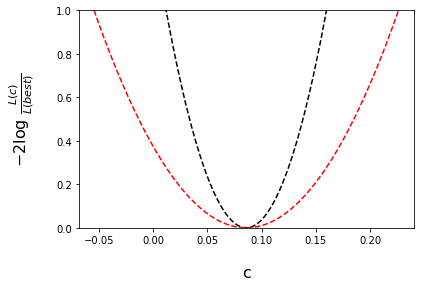

In [10]:
#  Scan likelihood contours
#  -  marginalise theta at every scan point, evaluate this contour at y=+1 to find the 1sigma uncertainties
#  -  fix theta to its best fit value, then the L-profile represents stat-only uncertainties

x = np.linspace(c_fit_val+c_err_low, c_fit_val+c_err_up, 101)
y_stat = np.array([TNLL(observed_dataset, xp, NP_fit_val) for xp in x]) - best_TNLL

y_tot = []
for xp in x :
    m = Minuit.from_array_func(fit_func, (xp,0.,), error=(1.,1.,), name=("c", "NP_lumi"), fix=(True,False), errordef=1.)
    m.migrad()
    y_tot.append(m.get_fmin().fval)
y_tot = np.array(y_tot) - best_TNLL
    
plt.plot(x, y_stat, "--", c="black")
plt.plot(x, y_tot, "--", c="red")
plt.gca().set_xlabel("c", fontsize=16, labelpad=20)
plt.gca().set_ylabel(r"$-2 \log$ $\frac{L(c)}{L(best)}$", fontsize=16, labelpad=20)
plt.gca().set_ylim([0,1])
plt.show()